# TensorFlow
Woo, it's tensorflow again. Let's build some graphs!

## Programming Model
Tensorflow expresses a numeric computation as a graph. Each node is an operation which has any number of inputs and outputs. Each edge is a tensor which flows between nodes. Suppose we have a simple network expressed by the following operation(s).

$$
h = \text{ReLU}(Wx + b)
$$

We can interpret it as three sequential operations.
![tf-graph](./assets/tf-graph.png)

## Node Types
New nodes are automatically built into the underlying graph. We can inspect what are the nodes inside our graph using `get_operations` on our default graph. As we can see there are multiple types of node.
```
tf.get_default_graph().get_operations()
```

### Variables
Variables are stateful nodes which output their current value. State is retained across multiple executions of a graph. We can think of variables as the parameters we wish to tune. The training will be occurred on variables instead of placeholders.
```python
b = tf.Variable(tf.zeros((100,)))
W = tf.Variable(tf.random_uniform((784, 100), -1, 1))
```

### Placeholder
Placeholders are nodes whose value is fed in at execution time.
```python
x = tf.placeholder(tf.float32, (100, 784))
```

### Mathematical operation
For example, we have `MatMul`, `Add`, `ReLU` and the list goes on.
```python
h = tf.nn.relu(tf.matmul(x, W), + b)
```

## Session
Once a graph is defined, we can deploy it with a session, which is a binding to a particular execution context. The `run` method has the followng signature.
```
sess.run(fetches, feeds)
```

### Arguments
There are two arguments we need to supply to a session.
* Fetches - List of graph nodes which will return outputs of these nodes
* Feeds - Dictionary mapping from graph nodes to concrete values which will specify the value of placeholder.

```python
sess = tf.Session()
sess.run(tf.initialize_all_variables())
sess.run(h, {x: np.random.random(100, 784)})
```

### Losses
Since labels are not parameters we are going to tune, we will use placeholder for them. In fact, loss is just a mathematical operation node.
```python
prediction = tf.nn.softmax(...) # Output of a neural network
label = tf.placeholder(tf.float32, [100, 10])
cross_entropy = -tf.reduce_sum(label * tf.log(prediction), axis=1)
```

### Optimizer
It's time to compute gradients! We need to first define an optimizer object. This should be a familiar concept to me, I have written many different types of optimizer in CS231n. 
```python
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
```

Each graph node has attached gradient operation. The gradient operation computes local gradient and combines it with upstream gradient with respect to loss. In order to use the gradient to update our parameters, we simply run the training step in a session.
```python
sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(1000):
    batch_x, batch_y = data.next_batch()
    sess.run(train_step, feed_dict={x: batch_x, label: batch_y})
```

### Shared Variables
What if you are running multiple sessions on a cluster of computers but you are still training one model, i.e. the same set of variables is being used across multiple machines/sessions? We can use `variable_scope`!
```python
with tf.variable_scope('foo'):
    v = tf._get_variable('v', shape=[1]) # v.name == "foo/v:0"
   
with tf.variable_scope('foo', reuse=True):
    v1 = tf.get_variable('v') # shared variable found!
   
with tf.variable_scope('foo', reuse=False):
    v1 = tf.get_variable('v') # CRASH foo/v:0 already exists
```

`variable_scope()` provides simple name-spacingto avoid clashes. `get_variable()` creates/accesses variables from within a variable scope. 
  

## Demo: Linear Regression

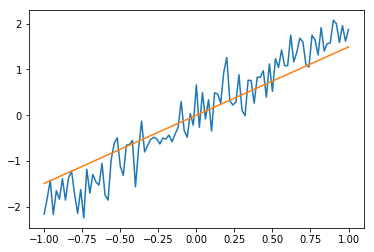

In [49]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


def generate_dataset():
    x_batch = np.linspace(-1, 1, 101)
    y_batch = 2 * x_batch + np.random.randn(*x_batch.shape) * 0.3 # Give it some noise
    return x_batch, y_batch


def linear_regression():
    x = tf.placeholder(tf.float32, shape=(None,), name='x') # Shape none makes it flexible
    y = tf.placeholder(tf.float32, shape=(None,), name='y')
    
    with tf.variable_scope('linreg') as scope:
        w = tf.Variable(np.random.normal(), name='W')
        y_pred = tf.multiply(x, w)
        loss = tf.reduce_mean(tf.square(y_pred - y))
    
    return x, y, y_pred, loss


def train():
    x_batch, y_batch = generate_dataset()
    x, y, y_pred, loss = linear_regression()
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        feed_dict = {x: x_batch, y: y_batch} # x is a tensor placeholder and is hashable
        for i in range(30):
            loss_val, _ = sess.run([loss, optimizer], feed_dict)
        
        y_pred_batch = sess.run(y_pred, {x: x_batch})
    
    plt.plot(x_batch, y_batch, x_batch, y_pred_batch)
    plt.show()

train()

## Demo: Word2Vec Skip-Gram

Each unprocessed input is a sentence. For example, "Ever since I use TypeScript, I can't go back to JavaScript".
For a window size of 1, the processed dataset should look like
```python
(['Ever', 'I'], 'since'), (['since', 'use'], 'I'), (['I', 'TypeScript'], 'use'), ...
```

Skip-Gram model tries to predict each context word from its target word. The final data set will look like.
```python
('since', 'Ever'), ('since', 'I'), ('I', 'since'), ('I', 'use'), ...
```

In [60]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

batch_size = 128
vocab_size = 50000
embed_size = 128 # Dimension of embedding vector
num_sampled = 64 # Number of negative examples to sample

def skip_gram():
    batch_inputs = tf.placeholder(tf.int32, shape=(batch_size,))
    batch_labels = tf.placeholder(tf.int32, shape=(batch_size, 1))
    with tf.variable_scope("word2vec") as scope:
        embeddings = tf.Variable(tf.random_uniform((vocab_size, embed_size), -1.0, 1.0))
        
        norm = tf.sqrt(tf.reduce_mean(tf.square(embeddings)), 1, keep_dims=True)
        norm_embeddings = embeddings/norm # Normalized embedding vectors
        
        w = tf.Variable(tf.truncated_normal((vocab_size, embed_size), stddev=1.0/np.sqrt(embed_size)))
        b = tf.Variable(tf.zeros((vocab_size)))
        loss = tf.nn.nce_loss(weights=w, 
                              biases=b,
                              inputs=batch_inputs,
                              labels=batch_labels,
                              num_sampled=num_sampled)
        
        mean_loss = tf.reduce_mean(loss)
        
        train_lookup = tf.nn.embedding_lookup(norm_embeddings, batch_inputs)
        val_lookup = tf.nn.embedding_lookup(norm_embeddings, val_batch_inputs)
        similarity = tf.matmul(val_lookup, norm_embeddings, transpose_b=True)
    
        return batch_inputs, batch_labels, norm_embeddings, loss, similarity
 
    
def train():
    train_data, val_data, reverse_dictionary = load_data()

    batch_inputs, batch_labels, norm_embeds, loss = skip_gram()
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for step, batch_data in enumerate(train_data):
            inputs, labels = batch_data
            feed_dict = {batch_inputs: inputs, batch_labels: labels}
            _, loss_val = sess.run([optimizer, loss], feed_dict)
            
            if step % 5000 == 0:
                sim = similarity.eval()
                print sim

Better source
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py